In [1]:
from typing import Dict, Iterable, Tuple
import warnings

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipp as sc
import scippneutron as scn

from halt.estimators import HistogramEstimator, KDEEstimator, MaximumLikelihoodEstimator
from halt.models import sphere, sphere_pdf

%matplotlib widget

In [2]:
SAMPLE_SIZE_RATIOS = [0.25, 0.5, 0.75, 1.0]
N_RESAMPLE = 1000
N_RESAMPLE_MLE = 40
COLOURS = {'KDE': 'C0', 'histogram': 'C1', 'MLE': 'C2', 'true': 'k'}

In [3]:
raw_events = scn.load('../data/mcstas_sphere.nxs')['EventData']
raw_events

<IPython.core.display.Javascript object>

<scipp.DataArray>
Dimensions: Sizes[spectrum:40000, tof:1, ]
Coordinates:
  position                vector_3_float64              [m]  (spectrum)  [(-0.056276, -0.497500, 23.555339), (-0.051277, -0.497500, 23.555219), ..., (0.933439, 0.497500, 23.531581), (0.938438, 0.497500, 23.531461)]
  sample_position         vector_3_float64              [m]  ()  [(0.347518, 0.000000, 19.644500)]
  source_position         vector_3_float64              [m]  ()  [(-0.125071, 0.000000, -0.048835)]
  spectrum                    int32  [dimensionless]  (spectrum)  [1, 2, ..., 39999, 40000]
  tof                       float64            [µs]  (tof [bin-edge])  [6014.078035, 82911.067824]
Data:
                          DataArrayView  [dimensionless]  (spectrum, tof)  [<scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  tof                       float64            [µs]  (event)  []
Data:
                            float32         [counts]  (event)  []  []

, <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  tof                       float64            [µs]  (event)  []
Data:
                            float32         [counts]  (event)  []  []

, ..., <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  tof                       float64            [µs]  (event)  []
Data:
                            float32         [counts]  (event)  []  []

, <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  tof                       float64            [µs]  (event)  []
Data:
                            float32         [counts]  (event)  []  []

]
Attributes:
  instrument_name            string  [dimensionless]  ()  ["McStas"]
  sample                   PyObject  [dimensionless]  ()  [<mantid.api._api.Sample object at 0x7f2e6c1f0520>]

In [4]:
q_events = scn.convert(raw_events, 'tof', 'Q', scatter=True)
q_events

<scipp.DataArray>
Dimensions: Sizes[spectrum:40000, Q:1, ]
Coordinates:
  Q                         float64           [1/Å]  (spectrum, Q [bin-edge])  [1.113833, 0.080794, ..., 1.113833, 0.080794]
  spectrum                    int32  [dimensionless]  (spectrum)  [1, 2, ..., 39999, 40000]
Data:
                          DataArrayView  [dimensionless]  (spectrum, Q)  [<scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  Q                         float64           [1/Å]  (event)  []
  pulse_time              datetime64             [ns]  (event)  []
Data:
                            float32         [counts]  (event)  []  []
Attributes:
  tof                       float64            [µs]  (event)  []
  wavelength                float64             [Å]  (event)  []

, <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  Q                         float64           [1/Å]  (event)  []
  pulse_time              datetime64             [ns]  (event)  []
Data:
                            float32         [counts]  (event)  []  []
Attributes:
  tof                       float64            [µs]  (event)  []
  wavelength                float64             [Å]  (event)  []

, ..., <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  Q                         float64           [1/Å]  (event)  []
  pulse_time              datetime64             [ns]  (event)  []
Data:
                            float32         [counts]  (event)  []  []
Attributes:
  tof                       float64            [µs]  (event)  []
  wavelength                float64             [Å]  (event)  []

, <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  Q                         float64           [1/Å]  (event)  []
  pulse_time              datetime64             [ns]  (event)  []
Data:
                            float32         [counts]  (event)  []  []
Attributes:
  tof                       float64            [µs]  (event)  []
  wavelength                float64             [Å]  (event)  []

]
Attributes:
  L1                        float64              [m]  ()  [19.699005]
  L2                        float64              [m]  (spectrum)  [3.962981, 3.962356, ..., 3.962349, 3.962973]
  Ltotal                    float64              [m]  (spectrum)  [23.661986, 23.661361, ..., 23.661354, 23.661978]
  incident_beam           vector_3_float64              [m]  ()  [(0.472589, 0.000000, 19.693335)]
  instrument_name            string  [dimensionless]  ()  ["McStas"]
  position                vector_3_float64              [m]  (spectrum)  [(-0.056276, -0.497500, 23.555339), (-0.051277, -0.497500, 23.555219), ..., (0.933439, 0.497500, 23.531581), (0.938438, 0.497500, 23.531461)]
  sample                   PyObject  [dimensionless]  ()  [<mantid.api._api.Sample object at 0x7f2e6c1f0520>]
  sample_position         vector_3_float64              [m]  ()  [(0.347518, 0.000000, 19.644500)]
  scattered_beam          vector_3_float64              [m]  (spectrum)  [(-0.403794, -0.497500, 3.910839), (-0.398795, -0.497500, 3.910719), ..., (0.585921, 0.497500, 3.887081), (0.590920, 0.497500, 3.886961)]
  source_position         vector_3_float64              [m]  ()  [(-0.125071, 0.000000, -0.048835)]
  tof                       float64            [µs]  (Q [bin-edge])  [6014.078035, 82911.067824]
  two_theta                 float64            [rad]  (spectrum)  [0.178482, 0.177606, ..., 0.177606, 0.178482]
  wavelength                float64             [Å]  (spectrum, Q [bin-edge])  [1.005490, 13.861854, ..., 1.005491, 13.861859]

In [5]:
q = q_events.data.bins.constituents['data'].coords['Q']
base_sample = q.values
q_unit = q.unit

In [6]:
def unary_fit(*args, **kwargs):
    (p,), ((_e,),) = scipy.optimize.curve_fit(*args, **kwargs)
    return p


def fit_r(data: sc.DataArray) -> sc.Variable:
    return sc.scalar(
        unary_fit(sphere_pdf,
                  xdata=data.coords['x'].values,
                  ydata=data.data.values,
                  p0=[1]))

In [7]:
rng = np.random.default_rng(174)

In [8]:
def estimate(sample, x, rng):
    estimators = (KDEEstimator(sample, x, {'r': fit_r}),
                  HistogramEstimator(sample, x, {'r': fit_r}))
    results = {estimator.name: estimator(N_RESAMPLE, rng) for estimator in estimators}
    mle = MaximumLikelihoodEstimator(sample, x, sphere)
    results[mle.name] = mle(N_RESAMPLE_MLE, rng)
    return results

In [9]:
x = np.linspace(0, 5, 1000)
sample_sizes = [int(ratio * len(base_sample)) for ratio in SAMPLE_SIZE_RATIOS]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    densities = {size: estimate(base_sample[:size], x, rng) for size in sample_sizes}

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [10]:
def find_xlim(densities: Iterable[sc.DataArray]) -> Tuple[float, float]:
    lo = min(map(lambda da: da.coords['x'].min().value, densities))
    hi = max(map(lambda da: da.coords['x'].max().value, densities))
    return float(lo), float(hi)


def errorstep(ax, x, y, e, c, **kwargs):
    ax.fill_between(x, y - e, y + e, step='mid', facecolor=c, alpha=0.5)
    ax.step(x, y, where='mid', c=c, **kwargs)


def errorfill(ax, x, y, e, c, **kwargs):
    ax.fill_between(x, y - e, y + e, facecolor=c, alpha=0.5)
    ax.plot(x, y, c=c, **kwargs)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
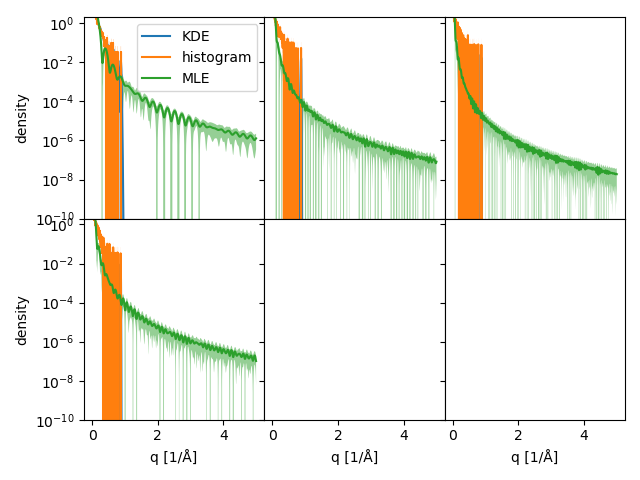

In [11]:
n_plots = len(densities)
fig, axs = plt.subplots(nrows=n_plots // 3 + min(n_plots % 3, 1), ncols=min(n_plots, 3),
                        squeeze=False, sharex='all', sharey='all',
                        gridspec_kw={'wspace': 0, 'hspace': 0})

for ax, (n, estimated) in zip(axs.flat, densities.items()):
    for name, data in estimated.items():
        fn = errorstep if name == 'histogram' else errorfill
        fn(ax, data.coords['x'].values, data.data.values, np.sqrt(data.data.variances),
           c=COLOURS[name], label=name)

    ax.set_yscale('log')
    ax.set_ylim((1e-10, 2))

for ax in axs[:, 0]:
    ax.set_ylabel('density')

for ax in axs[-1, :]:
    ax.set_xlabel(f'q [{q_unit}]')

axs[0, 0].legend()
fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
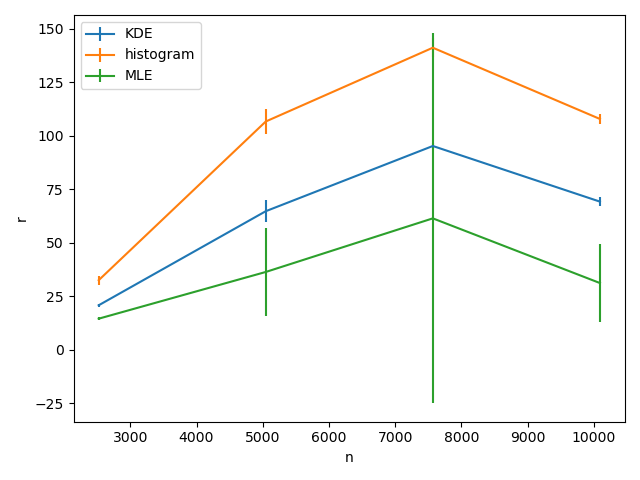

In [12]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('n')
ax.set_ylabel('r')

fit_results = {}
for n, per_n in densities.items():
    for name, result in per_n.items():
        fit_results.setdefault(name, []).append((n, result.attrs['r'].value, result.attrs['r'].variance))
for name, data in fit_results.items():
    x, y, e = zip(*data)
    ax.errorbar(x, y, e, c=COLOURS[name], label=name)

ax.legend()
fig.tight_layout()